In [3]:
import pandas as pd
import numpy as np

## 1) Try to create an Ensembling model
  - KNN + LogisticRegression 

In [4]:
def make_features(df):
    df['num_ingredients'] = df.ingredients.apply(len) #长度
    df['ingredients_length_mean'] = df.ingredients.apply(lambda x: np.mean([len(item) for item in x]))
    df['ingredients_length_sum'] = df.ingredients.apply(lambda x: np.sum([len(item) for item in x])) 
    df['ingredients_str'] = df.ingredients.astype(str)
    
    return df

In [5]:
train = make_features(pd.read_json("C:/Users/lijin/Desktop/ML-text-main/data/train.json"))
train.head()

,id,cuisine,ingredients,num_ingredients,ingredients_length_mean,ingredients_length_sum,ingredients_str
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,12.000000,108,"['romaine lettuce', 'black olives', 'grape tom..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,10.090909,111,"['plain flour', 'ground pepper', 'salt', 'toma..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,10.333333,124,"['eggs', 'pepper', 'salt', 'mayonaise', 'cooki..."
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,6.750000,27,"['water', 'vegetable oil', 'wheat', 'salt']"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,10.100000,202,"['black pepper', 'shallots', 'cornflour', 'cay..."


In [6]:
new = make_features(pd.read_json("C:/Users/lijin/Desktop/ML-text-main/data/test.json"))
new.head()

,id,ingredients,num_ingredients,ingredients_length_mean,ingredients_length_sum,ingredients_str
0,18009,"[baking powder, eggs, all-purpose flour, raisi...",6,9.333333,56,"['baking powder', 'eggs', 'all-purpose flour',..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...",11,10.272727,113,"['sugar', 'egg yolks', 'corn starch', 'cream o..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil...",6,9.666667,58,"['sausage links', 'fennel bulb', 'fronds', 'ol..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,...",21,12.000000,252,"['meat cuts', 'file powder', 'smoked sausage',..."
4,35687,"[ground black pepper, salt, sausage casings, l...",8,13.000000,104,"['ground black pepper', 'salt', 'sausage casin..."


- Use 3 columns for KNN as part 1 of ensembling model and (CountVectorizer + LogisticRegression) as part 2 of ensembling model

### model 1: KNN by using the self-created features

In [5]:
feature_cols = ['num_ingredients','ingredients_length_mean','ingredients_length_sum']
X = train[feature_cols]
y = train.cuisine

In [6]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1000)

In [7]:
knn.fit(X,y)

KNeighborsClassifier(n_neighbors=1000)

In [8]:
X_new = new[feature_cols]

In [9]:
new_pred_prob_knn = knn.predict_proba(X_new)
new_pred_prob_knn.shape

(9944, 20)

In [10]:
#print predict probabilities for the first row only
new_pred_prob_knn[0, :]

array([0.031, 0.032, 0.017, 0.044, 0.027, 0.075, 0.03 , 0.069, 0.036,
       0.149, 0.012, 0.08 , 0.02 , 0.132, 0.008, 0.014, 0.16 , 0.022,
       0.023, 0.019])

### model 2: LogisticRegression using the text_message

In [11]:
#引入通过ver1 找到的最好的参数
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
vect = CountVectorizer(token_pattern = r"\b\w\w+\b")

In [13]:
ct = make_column_transformer(
    (vect, 'ingredients_str'), #这列要使用CountVectorizer()
    remainder = 'drop' #其它列删除
    )

In [14]:
lg = LogisticRegression(C=1,solver='liblinear')

In [15]:
pipe = make_pipeline(ct,lg)
pipe.steps

[('columntransformer',
  ColumnTransformer(transformers=[('countvectorizer',
                                   CountVectorizer(token_pattern='\\b\\w\\w+\\b'),
                                   'ingredients_str')])),
 ('logisticregression', LogisticRegression(C=1, solver='liblinear'))]

In [16]:
pipe.fit(train,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('countvectorizer',
                                                  CountVectorizer(token_pattern='\\b\\w\\w+\\b'),
                                                  'ingredients_str')])),
                ('logisticregression',
                 LogisticRegression(C=1, solver='liblinear'))])

In [17]:
X_new = new
new_pred_prob_pipe = pipe.predict_proba(X_new)
new_pred_prob_pipe.shape

(9944, 20)

In [18]:
new_pred_prob_pipe[0,:]

array([0.01153098, 0.24217574, 0.00429293, 0.01534188, 0.03570195,
       0.01946003, 0.0103898 , 0.01656728, 0.18103444, 0.13768776,
       0.00427356, 0.05440133, 0.00543845, 0.04880836, 0.00205379,
       0.062607  , 0.11516431, 0.01353301, 0.01830388, 0.00123349])

### Ensembling these 2 models

In [19]:
#e.g. : Calculate the mean of the predicted probabilities for the 1st row
(new_pred_prob_knn[0, :] + new_pred_prob_pipe[0,:]) / 2

array([0.02126549, 0.13708787, 0.01064647, 0.02967094, 0.03135098,
       0.04723001, 0.0201949 , 0.04278364, 0.10851722, 0.14334388,
       0.00813678, 0.06720066, 0.01271923, 0.09040418, 0.0050269 ,
       0.0383035 , 0.13758215, 0.0177665 , 0.02065194, 0.01011675])

In [20]:
# calculate the mean of the predicted probabilities for all rows
new_pred_prob = pd.DataFrame((new_pred_prob_knn + new_pred_prob_pipe) / 2, columns=knn.classes_) #调用knn.classes_进行类别查看
new_pred_prob.head()

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
0,0.021265,0.137088,0.010646,0.029671,0.031351,0.047230,0.020195,0.042784,0.108517,0.143344,0.008137,0.067201,0.012719,0.090404,0.005027,0.038304,0.137582,0.017767,0.020652,0.010117
1,0.006942,0.017579,0.030135,0.044235,0.014836,0.083320,0.019354,0.049502,0.008575,0.086737,0.004588,0.024870,0.018008,0.071055,0.006501,0.006728,0.469239,0.009939,0.017003,0.010855
2,0.015878,0.023316,0.016630,0.031554,0.021177,0.043121,0.016797,0.040239,0.020185,0.466518,0.004965,0.037498,0.010944,0.082845,0.012474,0.012668,0.090205,0.022092,0.012543,0.018352
3,0.001673,0.003013,0.502568,0.042518,0.002031,0.023503,0.009002,0.063001,0.003001,0.077031,0.007860,0.003659,0.003001,0.114000,0.017511,0.004021,0.058251,0.010229,0.035501,0.018626
4,0.001871,0.013601,0.013857,0.024089,0.006017,0.051717,0.018266,0.015064,0.007974,0.594835,0.003124,0.013503,0.009092,0.080893,0.007350,0.003067,0.094900,0.022158,0.013018,0.005604


In [21]:
# for each row, find the column with the highest predicted probability
new_pred_class = new_pred_prob.idxmax(axis=1)
new_pred_class.head()

0         italian
1     southern_us
2         italian
3    cajun_creole
4         italian
dtype: object

In [22]:
# create a submission file (score: 0.77725)
pd.DataFrame({'id':new.id, 'cuisine':new_pred_class}).set_index('id').to_csv('sub_samli_02.csv')

- By using the self-created features with KNN is not performed well
- Try to create an ensembling model only based on the CountVectorizer by using SVC ,LogisticRegression,and RandomForest

## 2) Try to create the Ensembling model (VotingClassifier)

### model 1: svm.svc;model 2:random forest;model 3:logistic_regression

In [23]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [35]:
svc = SVC(kernel='rbf', C=1.0, gamma='auto',probability=True)
rfc = RandomForestClassifier(max_features=None)

In [36]:
from sklearn.ensemble import VotingClassifier
#vc = VotingClassifier([('clf1', svc),('clf2', rfc),('clf3', lg)])
vc = VotingClassifier([('clf1', svc),('clf2', rfc),('clf3', lg)],voting='soft',weights=(2,1,1))

In [37]:
pipe = make_pipeline(ct,vc)
pipe.steps

[('columntransformer',
  ColumnTransformer(transformers=[('countvectorizer',
                                   CountVectorizer(token_pattern='\\b\\w\\w+\\b'),
                                   'ingredients_str')])),
 ('votingclassifier',
  VotingClassifier(estimators=[('clf1', SVC(gamma='auto', probability=True)),
                               ('clf2',
                                RandomForestClassifier(max_features=None)),
                               ('clf3',
                                LogisticRegression(C=1, solver='liblinear'))],
                   voting='soft', weights=(2, 1, 1)))]

In [38]:
%time pipe.fit(train,y) #30+minutes ......

Wall time: 40min 36s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('countvectorizer',
                                                  CountVectorizer(token_pattern='\\b\\w\\w+\\b'),
                                                  'ingredients_str')])),
                ('votingclassifier',
                 VotingClassifier(estimators=[('clf1',
                                               SVC(gamma='auto',
                                                   probability=True)),
                                              ('clf2',
                                               RandomForestClassifier(max_features=None)),
                                              ('clf3',
                                               LogisticRegression(C=1,
                                                                  solver='liblinear'))],
                                  voting='soft', weights=(2, 1, 1)))])

In [28]:
#from sklearn.model_selection import GridSearchCV

In [29]:
#if you would like to tune the params
# param_grid = {}
# param_grid['columntransformer__countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]
# param_grid['votingclassifier__voting'] = ['soft','hard']
# param_grid['votingclassifier__weights'] = [(1,1,1),(2,1,1),(1,2,1),(1,1,2)]
# param_grid

In [30]:
#grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

In [31]:
#%time grid.fit(train,y)

In [32]:
# print(grid.best_params_)
# print(grid.best_score_)

In [33]:
#grid.best_estimator_

In [39]:
#predict for the new data
#X_new_predict = grid.predict(X_new)
X_new_predict = pipe.predict(X_new)

In [40]:
X_new_predict

array(['southern_us', 'southern_us', 'italian', ..., 'italian',
       'southern_us', 'mexican'], dtype=object)

In [41]:
pd.DataFrame({'id':X_new.id,'cuisine':X_new_predict}).set_index('id').to_csv('sub_samli_03.csv')

- 0.76297

## 3) Try to model stacking

### Locating groups of similar cuisine

In [7]:
train.ingredients_str

0        ['romaine lettuce', 'black olives', 'grape tom...
1        ['plain flour', 'ground pepper', 'salt', 'toma...
2        ['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...
3              ['water', 'vegetable oil', 'wheat', 'salt']
4        ['black pepper', 'shallots', 'cornflour', 'cay...
                               ...                        
39769    ['light brown sugar', 'granulated sugar', 'but...
39770    ['KRAFT Zesty Italian Dressing', 'purple onion...
39771    ['eggs', 'citrus fruit', 'raisins', 'sourdough...
39772    ['boneless chicken skinless thigh', 'minced ga...
39773    ['green chile', 'jalapeno chilies', 'onions', ...
Name: ingredients_str, Length: 39774, dtype: object

In [8]:
#combine all of the recipes into a single string for each type of cuisine
cuisine_ingredients = train.groupby('cuisine').ingredients_str.sum()
cuisine_ingredients.shape #20类，所以有20组ingredients_str

(20,)

In [9]:
#crate a document-term matrix from cuisine_ingredients
from sklearn.feature_extraction.text import TfidfVectorizer #用了TFIDF，与CountVectorizer的区别是前者主要按某一token在单独句子中出现的频率和所有句子中出现的频率进行词频token数量的提取
vect = TfidfVectorizer()
cuisine_dtm = vect.fit_transform(cuisine_ingredients)
cuisine_dtm.shape

(20, 3010)

In [10]:
# calculate the similarity between each cuisine and all other cuisines 【每个类别之间tokens的相关性】
from sklearn import metrics
cuisine_similarity = []
for idx in range(cuisine_dtm.shape[0]):
    similarity = metrics.pairwise.linear_kernel(cuisine_dtm[idx, :], cuisine_dtm).flatten()
    cuisine_similarity.append(similarity)

In [11]:
# convert the results to a DataFrame
cuisine_list = cuisine_ingredients.index
cuisine_similarity = pd.DataFrame(cuisine_similarity, index=cuisine_list, columns=cuisine_list)
cuisine_similarity

cuisine,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
cuisine,,,,,,,,,,,,,,,,,,,,
brazilian,1.000000,0.660232,0.742324,0.580756,0.769216,0.756392,0.695692,0.687271,0.665713,0.740527,0.778320,0.555601,0.571440,0.743736,0.669009,0.706087,0.743156,0.807694,0.685539,0.653801
british,0.660232,1.000000,0.591230,0.467640,0.631356,0.859609,0.562750,0.560349,0.926682,0.632618,0.662057,0.508296,0.447177,0.560446,0.543260,0.909551,0.911271,0.604000,0.445518,0.478901
cajun_creole,0.742324,0.591230,1.000000,0.605581,0.746151,0.708849,0.688391,0.618955,0.635197,0.738159,0.780897,0.532394,0.578645,0.724877,0.649831,0.657802,0.747480,0.803637,0.590103,0.605224
chinese,0.580756,0.467640,0.605581,1.000000,0.839803,0.540446,0.496090,0.553532,0.460746,0.555504,0.635953,0.835587,0.866828,0.561837,0.505655,0.521844,0.558514,0.603526,0.755813,0.817005
filipino,0.769216,0.631356,0.746151,0.839803,1.000000,0.682939,0.607436,0.655934,0.641010,0.670628,0.792723,0.748558,0.782623,0.678302,0.614984,0.697000,0.720368,0.727409,0.741512,0.806833
french,0.756392,0.859609,0.708849,0.540446,0.682939,1.000000,0.759936,0.624868,0.837384,0.835272,0.723225,0.540279,0.502205,0.666830,0.685384,0.881173,0.862062,0.817541,0.548375,0.570925
greek,0.695692,0.562750,0.688391,0.496090,0.607436,0.759936,1.000000,0.640297,0.583675,0.859270,0.681281,0.469465,0.479835,0.696644,0.769412,0.649530,0.641229,0.837448,0.519004,0.538683
indian,0.687271,0.560349,0.618955,0.553532,0.655934,0.624868,0.640297,1.000000,0.577338,0.616211,0.734926,0.567993,0.538853,0.708621,0.795271,0.607432,0.617278,0.678865,0.627460,0.605162
irish,0.665713,0.926682,0.635197,0.460746,0.641010,0.837384,0.583675,0.577338,1.000000,0.649878,0.680914,0.494762,0.458798,0.591718,0.563303,0.892428,0.902850,0.630921,0.449931,0.481712


<AxesSubplot:xlabel='cuisine', ylabel='cuisine'>

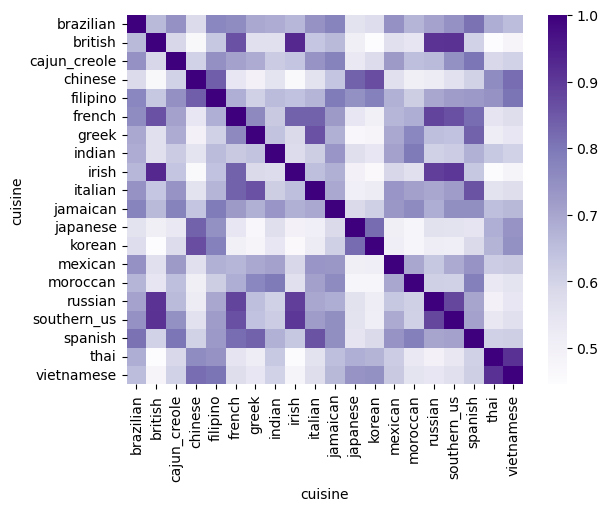

In [19]:
# create a heatmap
%matplotlib inline
import seaborn as sns
sns.heatmap(cuisine_similarity, cmap='Purples')

- 颜色越深，代表相关性越高

In [20]:
#根据上图相关性，大致手动分出来4组
group_1 = ['chinese', 'filipino', 'japanese', 'korean', 'thai', 'vietnamese']
group_2 = ['british', 'french', 'irish', 'russian', 'southern_us']
group_3 = ['greek', 'italian', 'moroccan', 'spanish']
group_4 = ['brazilian', 'cajun_creole', 'indian', 'jamaican', 'mexican']

In [21]:
# create a dictionary that maps each cuisine to its group number 用于在原df中标号
cuisines = group_1 + group_2 + group_3 + group_4
group_numbers = [1]*len(group_1) + [2]*len(group_2) + [3]*len(group_3) + [4]*len(group_4)
cuisine_to_group = dict(zip(cuisines, group_numbers))
cuisine_to_group

{'chinese': 1,
 'filipino': 1,
 'japanese': 1,
 'korean': 1,
 'thai': 1,
 'vietnamese': 1,
 'british': 2,
 'french': 2,
 'irish': 2,
 'russian': 2,
 'southern_us': 2,
 'greek': 3,
 'italian': 3,
 'moroccan': 3,
 'spanish': 3,
 'brazilian': 4,
 'cajun_creole': 4,
 'indian': 4,
 'jamaican': 4,
 'mexican': 4}

In [22]:
#map the cuisines to their group numbers
train['group'] = train.cuisine.map(cuisine_to_group)
train.head()

,id,cuisine,ingredients,num_ingredients,ingredients_length_mean,ingredients_length_sum,ingredients_str,group
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,12.000000,108,"['romaine lettuce', 'black olives', 'grape tom...",3
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,10.090909,111,"['plain flour', 'ground pepper', 'salt', 'toma...",2
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,10.333333,124,"['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...",1
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,6.750000,27,"['water', 'vegetable oil', 'wheat', 'salt']",4
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,10.100000,202,"['black pepper', 'shallots', 'cornflour', 'cay...",4


In [23]:
train.group.isnull().sum() #检查是不是都已经被成功分组了

0

- 任务1：用ingredients_str列的CountVectorizer之后，预测which group (1,2,3,4)

In [91]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
X = train.ingredients_str #这里不再用整体进行train了
y = train.group
pipe_main = make_pipeline(CountVectorizer(), LogisticRegression(solver='liblinear'))

pipe_main.steps

[('countvectorizer', CountVectorizer()),
 ('logisticregression', LogisticRegression(solver='liblinear'))]

In [55]:
#简单调个参
from sklearn.model_selection import GridSearchCV
param_grid = {}
param_grid['countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]
param_grid['logisticregression__C'] = [0.5,1]

grid = GridSearchCV(pipe_main, param_grid, cv=5, scoring='accuracy')
grid.fit(X,y)

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'countvectorizer__token_pattern': ['\\b\\w\\w+\\b',
                                                            "'([a-z ]+)'"],
                         'logisticregression__C': [0.5, 1]},
             scoring='accuracy')

In [56]:
print(grid.best_params_)
print(grid.best_score_)

{'countvectorizer__token_pattern': '\\b\\w\\w+\\b', 'logisticregression__C': 0.5}
0.8694373730028746


In [57]:
grid.best_estimator_

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(token_pattern='\\b\\w\\w+\\b')),
                ('logisticregression', LogisticRegression(C=0.5))])

In [92]:
#试试RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy as sp
param_grid = {}
param_grid['countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]
param_grid['logisticregression__C'] = sp.stats.uniform(scale=1)
param_grid

{'countvectorizer__token_pattern': ['\\b\\w\\w+\\b', "'([a-z ]+)'"],
 'logisticregression__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x203c2fe4c10>}

In [93]:
np.random.seed(1)

In [94]:
rand = RandomizedSearchCV(pipe_main, param_grid, cv=5, scoring='accuracy', n_iter=5, random_state=1)

In [95]:
%time rand.fit(X, y)

Wall time: 21.7 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer()),
                                             ('logisticregression',
                                              LogisticRegression(solver='liblinear'))]),
                   n_iter=5,
                   param_distributions={'countvectorizer__token_pattern': ['\\b\\w\\w+\\b',
                                                                           "'([a-z "
                                                                           "]+)'"],
                                        'logisticregression__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000203C2FE4C10>},
                   random_state=1, scoring='accuracy')

In [96]:
print(rand.best_score_)
print(rand.best_params_)

0.8700659085151312
{'countvectorizer__token_pattern': '\\b\\w\\w+\\b', 'logisticregression__C': 0.3879107411620074}


- 任务2：再在每组中预测exact type

In [58]:
# define an X and y for each cuisine group
X1 = train.loc[train.group==1, 'ingredients_str']
y1 = train.loc[train.group==1, 'cuisine']
X2 = train.loc[train.group==2, 'ingredients_str']
y2 = train.loc[train.group==2, 'cuisine']
X3 = train.loc[train.group==3, 'ingredients_str']
y3 = train.loc[train.group==3, 'cuisine']
X4 = train.loc[train.group==4, 'ingredients_str']
y4 = train.loc[train.group==4, 'cuisine']

In [98]:
# define a pipeline for each cuisine group
pipe_1 = make_pipeline(CountVectorizer(token_pattern='\\b\\w\\w+\\b'), LogisticRegression(C=1,solver='liblinear'))
pipe_2 = make_pipeline(CountVectorizer(token_pattern='\\b\\w\\w+\\b'), LogisticRegression(C=1,solver='liblinear'))
pipe_3 = make_pipeline(CountVectorizer(token_pattern='\\b\\w\\w+\\b'), LogisticRegression(C=1,solver='liblinear'))
pipe_4 = make_pipeline(CountVectorizer(token_pattern='\\b\\w\\w+\\b'), LogisticRegression(C=1,solver='liblinear'))

In [101]:
param_grid = {}
param_grid['countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]
param_grid['logisticregression__C'] = [0.5,1]

grid_1 = GridSearchCV(pipe_1, param_grid, cv=5, scoring='accuracy')
grid_1.fit(X1,y1)

param_grid = {}
param_grid['countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]
param_grid['logisticregression__C'] = [0.5,1]

grid_2 = GridSearchCV(pipe_2, param_grid, cv=5, scoring='accuracy')
grid_2.fit(X2,y2)

param_grid = {}
param_grid['countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]
param_grid['logisticregression__C'] = [0.5,1]

grid_3 = GridSearchCV(pipe_3, param_grid, cv=5, scoring='accuracy')
grid_3.fit(X3,y3)

param_grid = {}
param_grid['countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]
param_grid['logisticregression__C'] = [0.5,1]

grid_4 = GridSearchCV(pipe_4, param_grid, cv=5, scoring='accuracy')
grid_4.fit(X4,y4)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(token_pattern='\\b\\w\\w+\\b')),
                                       ('logisticregression',
                                        LogisticRegression(C=1,
                                                           solver='liblinear'))]),
             param_grid={'countvectorizer__token_pattern': ['\\b\\w\\w+\\b',
                                                            "'([a-z ]+)'"],
                         'logisticregression__C': [0.5, 1]},
             scoring='accuracy')

In [99]:
param_grid = {}
param_grid['countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]
param_grid['logisticregression__C'] = sp.stats.uniform(scale=1)

rand_1 = RandomizedSearchCV(pipe_1, param_grid, cv=5, scoring='accuracy', n_iter=5, random_state=1)
rand_1.fit(X1,y1)

rand_2 = RandomizedSearchCV(pipe_2, param_grid, cv=5, scoring='accuracy', n_iter=5, random_state=1)
rand_2.fit(X2,y2)

rand_3 = RandomizedSearchCV(pipe_3, param_grid, cv=5, scoring='accuracy', n_iter=5, random_state=1)
rand_3.fit(X3,y3)

rand_4 = RandomizedSearchCV(pipe_4, param_grid, cv=5, scoring='accuracy', n_iter=5, random_state=1)
rand_4.fit(X4,y4)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(token_pattern='\\b\\w\\w+\\b')),
                                             ('logisticregression',
                                              LogisticRegression(C=1,
                                                                 solver='liblinear'))]),
                   n_iter=5,
                   param_distributions={'countvectorizer__token_pattern': ['\\b\\w\\w+\\b',
                                                                           "'([a-z "
                                                                           "]+)'"],
                                        'logisticregression__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000203C3563550>},
                   random_state=1, scoring='accuracy')

In [102]:
print(grid_1.best_params_)
print(grid_1.best_score_)
print(grid_2.best_params_)
print(grid_2.best_score_)
print(grid_3.best_params_)
print(grid_3.best_score_)
print(grid_4.best_params_)
print(grid_4.best_score_)

{'countvectorizer__token_pattern': '\\b\\w\\w+\\b', 'logisticregression__C': 1}
0.8037290242386576
{'countvectorizer__token_pattern': '\\b\\w\\w+\\b', 'logisticregression__C': 1}
0.801927283791456
{'countvectorizer__token_pattern': '\\b\\w\\w+\\b', 'logisticregression__C': 1}
0.9073256692550362
{'countvectorizer__token_pattern': '\\b\\w\\w+\\b', 'logisticregression__C': 1}
0.9435726210350583


In [100]:
print(rand_1.best_params_)
print(rand_1.best_score_)
print(rand_2.best_params_)
print(rand_2.best_score_)
print(rand_3.best_params_)
print(rand_3.best_score_)
print(rand_4.best_params_)
print(rand_4.best_score_)

{'countvectorizer__token_pattern': '\\b\\w\\w+\\b', 'logisticregression__C': 0.3879107411620074}
0.800994406463642
{'countvectorizer__token_pattern': '\\b\\w\\w+\\b', 'logisticregression__C': 0.3879107411620074}
0.7957661362417306
{'countvectorizer__token_pattern': '\\b\\w\\w+\\b', 'logisticregression__C': 0.3879107411620074}
0.9048310587271027
{'countvectorizer__token_pattern': '\\b\\w\\w+\\b', 'logisticregression__C': 0.3879107411620074}
0.9413188647746245


In [36]:
# within each cuisine group, calculate the cross-validated accuracy
print(cross_val_score(pipe_1, X1, y1, cv=5, scoring='accuracy').mean())
print(cross_val_score(pipe_2, X2, y2, cv=5, scoring='accuracy').mean())
print(cross_val_score(pipe_3, X3, y3, cv=5, scoring='accuracy').mean())
print(cross_val_score(pipe_4, X4, y4, cv=5, scoring='accuracy').mean())

0.8037290242386576
0.801927283791456
0.9073256692550362
0.9435726210350583


### making predictions for the new data

In [37]:
# fit each pipeline with the relevant X and y
pipe_main.fit(X, y) #task 1
pipe_1.fit(X1, y1) #task 2.1
pipe_2.fit(X2, y2) #task 2.2
pipe_3.fit(X3, y3) #task 2.3
pipe_4.fit(X4, y4) #task 2.4

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(token_pattern='\\b\\w\\w+\\b')),
                ('logisticregression',
                 LogisticRegression(C=1, solver='liblinear'))])

In [62]:
grid.fit(X, y) #task 1
grid_1.fit(X1, y1) #task 2.1
grid_2.fit(X2, y2) #task 2.2
grid_3.fit(X3, y3) #task 2.3
grid_4.fit(X4, y4) #task 2.4

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(token_pattern='\\b\\w\\w+\\b')),
                                       ('logisticregression',
                                        LogisticRegression(C=1,
                                                           solver='liblinear'))]),
             param_grid={'countvectorizer__token_pattern': ['\\b\\w\\w+\\b',
                                                            "'([a-z ]+)'"],
                         'logisticregression__C': [0.5, 1]},
             scoring='accuracy')

- rand 分X，y；grid_n分X1,y1

In [103]:
rand.fit(X, y) #task 1
grid_1.fit(X1, y1) #task 2.1
grid_2.fit(X2, y2) #task 2.2
grid_3.fit(X3, y3) #task 2.3
grid_4.fit(X4, y4) #task 2.4

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(token_pattern='\\b\\w\\w+\\b')),
                                       ('logisticregression',
                                        LogisticRegression(C=1,
                                                           solver='liblinear'))]),
             param_grid={'countvectorizer__token_pattern': ['\\b\\w\\w+\\b',
                                                            "'([a-z ]+)'"],
                         'logisticregression__C': [0.5, 1]},
             scoring='accuracy')

- step 1 :predict which group are each test_data

In [104]:
# for the new data, first make cuisine group predictions
X_new = new.ingredients_str
new_pred_group = rand.predict(X_new)
new_pred_group

array([2, 2, 3, ..., 3, 2, 4], dtype=int64)

In [63]:
X_new = new.ingredients_str
new_pred_group = grid.predict(X_new)
new_pred_group

array([2, 2, 3, ..., 3, 2, 4], dtype=int64)

- step 2: predict which exact type for the data in each group

In [105]:
'''
new_pred_class_1 = pipe_1.predict(X_new[new_pred_group==1])
new_pred_class_2 = pipe_2.predict(X_new[new_pred_group==2])
new_pred_class_3 = pipe_3.predict(X_new[new_pred_group==3])
new_pred_class_4 = pipe_4.predict(X_new[new_pred_group==4])
print(new_pred_class_1)
print(new_pred_class_2)
print(new_pred_class_3)
print(new_pred_class_4)
'''
new_pred_class_1 = grid_1.predict(X_new[new_pred_group==1])
new_pred_class_2 = grid_2.predict(X_new[new_pred_group==2])
new_pred_class_3 = grid_3.predict(X_new[new_pred_group==3])
new_pred_class_4 = grid_4.predict(X_new[new_pred_group==4])
print(new_pred_class_1)
print(new_pred_class_2)
print(new_pred_class_3)
print(new_pred_class_4)

['chinese' 'japanese' 'vietnamese' ... 'thai' 'chinese' 'thai']
['british' 'southern_us' 'southern_us' ... 'french' 'southern_us'
 'southern_us']
['italian' 'italian' 'italian' ... 'italian' 'italian' 'italian']
['cajun_creole' 'mexican' 'indian' ... 'mexican' 'indian' 'mexican']


In [106]:
# add the cuisine predictions to the DataFrame of new data
new.loc[new_pred_group==1, 'pred_class'] = new_pred_class_1
new.loc[new_pred_group==2, 'pred_class'] = new_pred_class_2
new.loc[new_pred_group==3, 'pred_class'] = new_pred_class_3
new.loc[new_pred_group==4, 'pred_class'] = new_pred_class_4

In [107]:
new.head()

,id,ingredients,num_ingredients,ingredients_length_mean,ingredients_length_sum,ingredients_str,pred_class
0,18009,"[baking powder, eggs, all-purpose flour, raisi...",6,9.333333,56,"['baking powder', 'eggs', 'all-purpose flour',...",british
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...",11,10.272727,113,"['sugar', 'egg yolks', 'corn starch', 'cream o...",southern_us
2,41580,"[sausage links, fennel bulb, fronds, olive oil...",6,9.666667,58,"['sausage links', 'fennel bulb', 'fronds', 'ol...",italian
3,29752,"[meat cuts, file powder, smoked sausage, okra,...",21,12.000000,252,"['meat cuts', 'file powder', 'smoked sausage',...",cajun_creole
4,35687,"[ground black pepper, salt, sausage casings, l...",8,13.000000,104,"['ground black pepper', 'salt', 'sausage casin...",italian


In [68]:
pd.DataFrame({'id':new.id, 'cuisine':new.pred_class}).set_index('id').to_csv('sub_samli_04.csv')

In [108]:
pd.DataFrame({'id':new.id, 'cuisine':new.pred_class}).set_index('id').to_csv('sub_samli_06.csv') #combine randomSearch and gridSearch based on linear regression

### 换成linearSVC分类器呢？

In [69]:
from sklearn.svm import LinearSVC
pipe_main = make_pipeline(CountVectorizer(), LinearSVC(C=0.78, penalty='l2', loss='squared_hinge', dual=True, max_iter=1000, random_state=0))
pipe_main.steps

[('countvectorizer', CountVectorizer()),
 ('linearsvc', LinearSVC(C=0.78, random_state=0))]

In [70]:
param_grid = {}
param_grid['countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]
grid_main = GridSearchCV(pipe_main, param_grid, cv=5, scoring='accuracy')
grid_main.fit(X,y)

D:\anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('linearsvc',
                                        LinearSVC(C=0.78, random_state=0))]),
             param_grid={'countvectorizer__token_pattern': ['\\b\\w\\w+\\b',
                                                            "'([a-z ]+)'"]},
             scoring='accuracy')

In [72]:
print(grid_main.best_params_)
print(grid_main.best_score_)

{'countvectorizer__token_pattern': '\\b\\w\\w+\\b'}
0.8685323103128976


In [73]:
pipe_1 = make_pipeline(CountVectorizer(), LinearSVC(C=0.78, penalty='l2', loss='squared_hinge', dual=True, max_iter=1000, random_state=0))
pipe_2 = make_pipeline(CountVectorizer(), LinearSVC(C=0.78, penalty='l2', loss='squared_hinge', dual=True, max_iter=1000, random_state=0))
pipe_3 = make_pipeline(CountVectorizer(), LinearSVC(C=0.78, penalty='l2', loss='squared_hinge', dual=True, max_iter=1000, random_state=0))
pipe_4 = make_pipeline(CountVectorizer(), LinearSVC(C=0.78, penalty='l2', loss='squared_hinge', dual=True, max_iter=1000, random_state=0))

In [74]:
param_grid = {}
param_grid['countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]

grid_1 = GridSearchCV(pipe_1, param_grid, cv=5, scoring='accuracy')
grid_1.fit(X1,y1)

param_grid = {}
param_grid['countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]

grid_2 = GridSearchCV(pipe_2, param_grid, cv=5, scoring='accuracy')
grid_2.fit(X2,y2)

param_grid = {}
param_grid['countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]

grid_3 = GridSearchCV(pipe_3, param_grid, cv=5, scoring='accuracy')
grid_3.fit(X3,y3)

param_grid = {}
param_grid['countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-z ]+)'"]

grid_4 = GridSearchCV(pipe_4, param_grid, cv=5, scoring='accuracy')
grid_4.fit(X4,y4)

D:\anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\svm\_bas

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('linearsvc',
                                        LinearSVC(C=0.78, random_state=0))]),
             param_grid={'countvectorizer__token_pattern': ['\\b\\w\\w+\\b',
                                                            "'([a-z ]+)'"]},
             scoring='accuracy')

In [75]:
print(grid_1.best_params_)
print(grid_1.best_score_)
print(grid_2.best_params_)
print(grid_2.best_score_)
print(grid_3.best_params_)
print(grid_3.best_score_)
print(grid_4.best_params_)
print(grid_4.best_score_)

{'countvectorizer__token_pattern': '\\b\\w\\w+\\b'}
0.791547545059043
{'countvectorizer__token_pattern': '\\b\\w\\w+\\b'}
0.7890434471661004
{'countvectorizer__token_pattern': '\\b\\w\\w+\\b'}
0.9007655398223289
{'countvectorizer__token_pattern': '\\b\\w\\w+\\b'}
0.9380634390651086


In [76]:
grid_main.fit(X, y) #task 1
grid_1.fit(X1, y1) #task 2.1
grid_2.fit(X2, y2) #task 2.2
grid_3.fit(X3, y3) #task 2.3
grid_4.fit(X4, y4) #task 2.4

D:\anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\svm\_bas

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('linearsvc',
                                        LinearSVC(C=0.78, random_state=0))]),
             param_grid={'countvectorizer__token_pattern': ['\\b\\w\\w+\\b',
                                                            "'([a-z ]+)'"]},
             scoring='accuracy')

In [77]:
X_new = new.ingredients_str
new_pred_group = grid_main.predict(X_new)
new_pred_group

array([2, 2, 3, ..., 3, 2, 4], dtype=int64)

In [78]:
new_pred_class_1 = grid_1.predict(X_new[new_pred_group==1])
new_pred_class_2 = grid_2.predict(X_new[new_pred_group==2])
new_pred_class_3 = grid_3.predict(X_new[new_pred_group==3])
new_pred_class_4 = grid_4.predict(X_new[new_pred_group==4])
print(new_pred_class_1)
print(new_pred_class_2)
print(new_pred_class_3)
print(new_pred_class_4)

['chinese' 'japanese' 'vietnamese' ... 'thai' 'chinese' 'chinese']
['irish' 'southern_us' 'southern_us' ... 'french' 'southern_us'
 'southern_us']
['italian' 'italian' 'italian' ... 'italian' 'italian' 'italian']
['cajun_creole' 'mexican' 'indian' ... 'mexican' 'indian' 'mexican']


In [79]:
new.loc[new_pred_group==1, 'pred_class'] = new_pred_class_1
new.loc[new_pred_group==2, 'pred_class'] = new_pred_class_2
new.loc[new_pred_group==3, 'pred_class'] = new_pred_class_3
new.loc[new_pred_group==4, 'pred_class'] = new_pred_class_4

In [80]:
pd.DataFrame({'id':new.id, 'cuisine':new.pred_class}).set_index('id').to_csv('sub_samli_05.csv')